In [1]:
# Set a jupyter notebook coding container to fit the borders of a web browser.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [27]:
# Data structure
import pandas as pd
import numpy as np

# Statistics
import math
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols, logit
from scipy.stats import chi2_contingency

# Ploting
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Do not need to call plt.show() when ploting a graph
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # add plot figure back line

import seaborn as sns
sns.set()

In [3]:
# GridSearch
from sklearn.model_selection import GridSearchCV

# Outliers remover
from sklearn.ensemble import IsolationForest

# Data Preparations
from sklearn.model_selection import train_test_split

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Main Model
import xgboost as xgb

# Models for justification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree

# Model comparison
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [4]:
#Set max display columns to max
pd.set_option('display.max_columns', None)

## Load data

In [5]:
# The list of the names that represent the missing values
missing_values = ["n/a", "na", "--","Unknown"]

In [29]:
raw_data = pd.read_csv("data/BankChurners.csv", na_values = missing_values)

In [7]:
# Drop the results of Navie_bayes Classifier
raw_data.drop(list(raw_data.iloc[:,-2:].columns),inplace=True,axis=1)

## Data exploration

In [8]:
raw_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [9]:
def drop_unbalanced_ratio(df):
    """ 
    Drop column that has an unbalanced unique value ratio (one unique value or excessive unique values).
    
    Notes:
    - One unique value or too many unique values columns doesn't give a decent analysis 
    because it doesn't give meaningful information.
    
    Args:
    df: dataframe. The pandas dataframe.
    
    Returns:
    data: The dataframe that dropped column that has one unique value or excessive unique values.
    
    """
    
    data = df.copy()
    
    print("\nDropped unbalanced ratio columns...")
    
    # Drop the columns that contain one unique value or 
    # Drop the column that has unique variables equal to the number of values. (Too many unqiue values inside)
    for col_name in data.columns:
        if data[col_name].count() == len(data[col_name].unique()) or len(data[col_name].unique()) == 1:
            print (col_name)
            data.drop(col_name, axis=1,inplace = True)

    return data

# Chi-square test
def Chi_square_test(df, target):
    p_values = []
    # Select only categorical columns
    cat_feats = df.select_dtypes(exclude=['number']).drop(target,axis=1).copy()
    for col_name in cat_feats.columns:
        # pd.crosstab: get observed values 
        # Calculate p-values
        stat, p, dof, expected = chi2_contingency(pd.crosstab(df[target], raw_data[col_name]))
        # Store p-value for each column
        p_values.append(p)
    # Create DataFrame for holding p-values
    return pd.DataFrame(data={'column name': cat_feats.columns,'p-value':p_values})

def z_outlier_filter(df):
    """ 
    Filter outliner by statistic z score.
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values in each column.
    
    Returns:
    filtered_df: The removed outliner dataframe by using z score.
    
    """
    data = df.copy()
    
    # Calculate z-scores
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    
    # Set NaN to 0
    abs_z_scores[np.isnan(abs_z_scores)]= 0

    # The columns that have z-score > 3 are dropped
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    filtered_df = data[filtered_entries]
    return filtered_df

def ML_outlier_filter(df):
    """ 
    Filter outlier by Isolation Forest
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values and not contain any missing values.
    
    Returns:
    anomaly_solved: The removed outlier dataframe by using machine learning (isolationForest).
    
    """
    data = df.copy()
    # Define IsolationForest
    clf = IsolationForest(max_samples=100, random_state = 42, contamination= 'auto')
    data['anomaly'] = clf.fit_predict(data)
    
    # Select normal datapoints
    anomaly_solved = data[data['anomaly'] == 1]
    anomaly_solved = anomaly_solved.drop('anomaly',axis=1)
    return anomaly_solved

In [10]:
def countplot(df, col_name, size_x=4, size_y=5):
    plt.figure(figsize=(size_x, size_y))
    ax = sns.countplot(x = col_name, data = df, palette="muted", order = df[col_name].value_counts().index)
    plt.ylabel('The number of customers')

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(str(round(height/len(df[col_name])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

def plot_scatter(df, feature, target, size_x=5, size_y=4, s=10):
    """ 
    Plot scatter plot in pair.
    
    Args:
    df: dataframe. The pandas dataframe.
    feature: dataframe serie. The numeric feature pandas serie.
    target: dataframe serie. The numeric target pandas serie.
    size_x: float. x axis size.
    size_y: float. y axis size.
    s: float. a marker size.
    
    """
    data = df.copy()
    
    plt.figure(figsize=(size_x, size_y))
    plt.scatter(data[target],data[feature], s=s)
    plt.show()   

def plot_pearson_corrs(df, size_x = 10, size_y = 7):
    """ 
    Plot Pearson's correlations
    
    Args:
    df: dataframe. The feature pandas dataframe.
    size_x: float. x axis size.
    size_y: float. y axis size.
    
    """
    # Set the size of axi
    plt.figure(figsize=(size_x,size_y))
    # Get Pearson correlation coefficient 
    cor = df.corr()
    # Plot heatmap
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show

## Data exploration

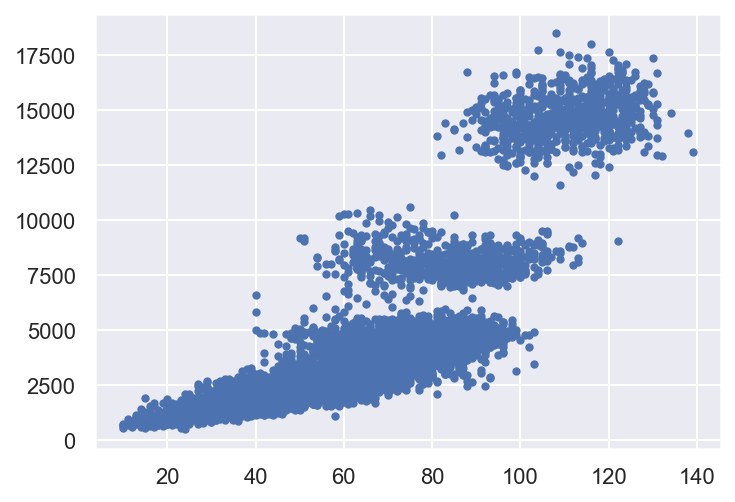

In [11]:
plot_scatter(raw_data,'Total_Trans_Amt','Total_Trans_Ct')

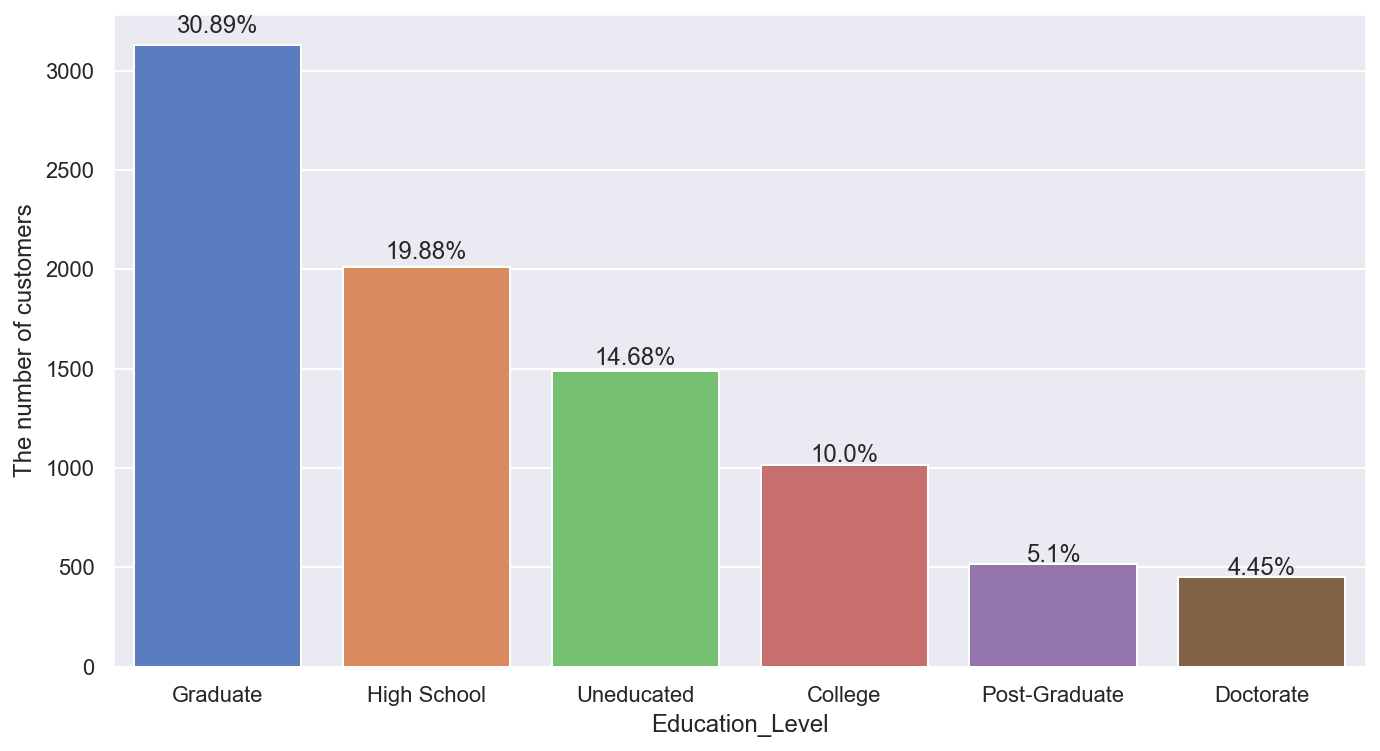

In [12]:
countplot(raw_data, 'Education_Level', 10, 6)

<AxesSubplot:xlabel='Credit_Limit', ylabel='Count'>

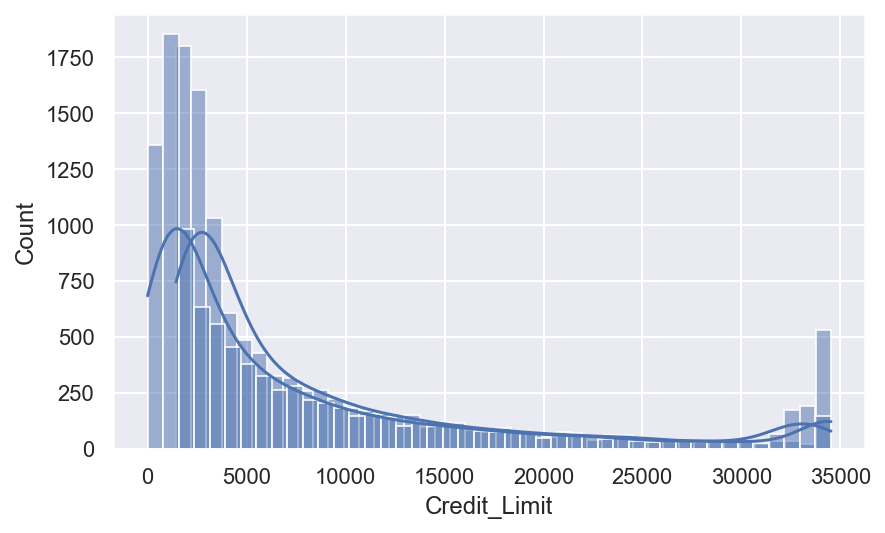

In [13]:
# Similar
sns.histplot(raw_data['Credit_Limit'], kde=True)
sns.histplot(raw_data['Avg_Open_To_Buy'], kde=True)

<AxesSubplot:xlabel='Total_Trans_Amt', ylabel='Count'>

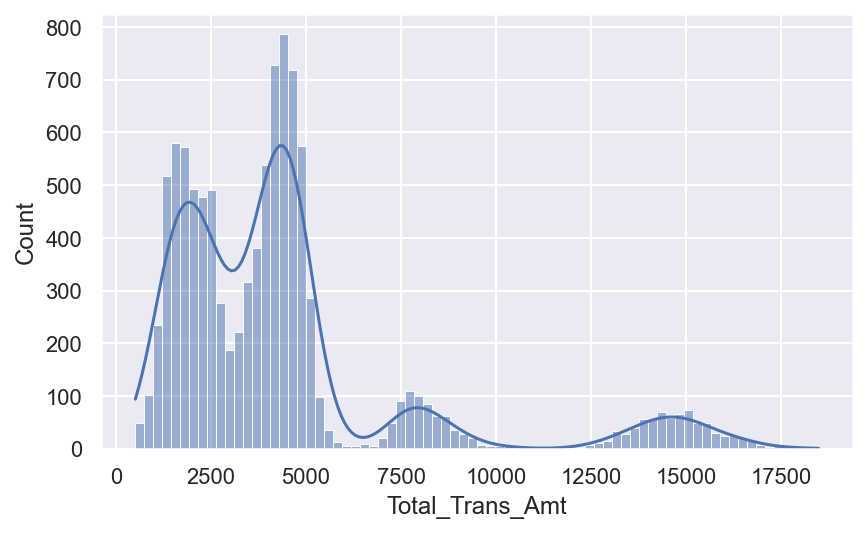

In [14]:
# Remove
sns.histplot(raw_data['Total_Trans_Amt'], kde=True)

<AxesSubplot:xlabel='Total_Trans_Ct', ylabel='Count'>

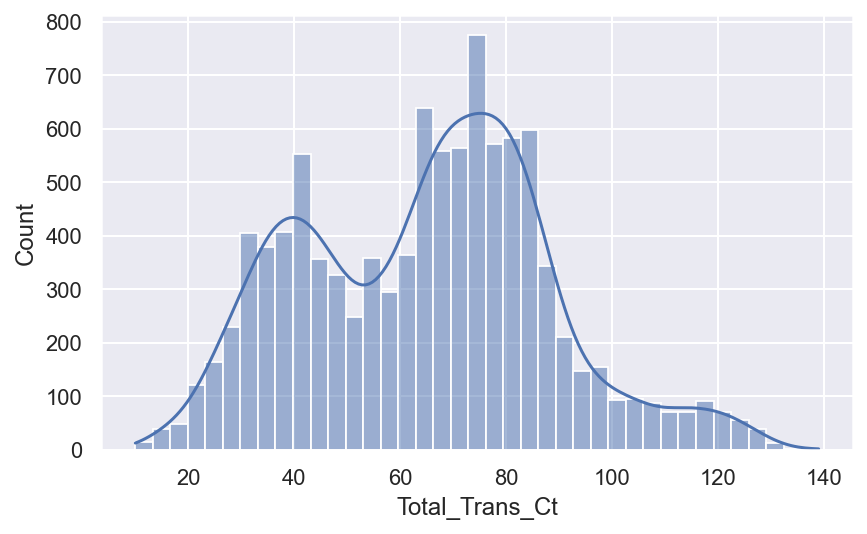

In [15]:
sns.histplot(raw_data['Total_Trans_Ct'], kde=True)

## Cleaning data

In [16]:
# Check NaN
raw_data.columns[raw_data.isnull().mean()>0.75]

Index([], dtype='object')

In [17]:
# Drop NaN values
df = raw_data.dropna()

In [18]:
# Drop unbalanced ratio
drop_unbalanced_ratio(df)


Dropped unbalanced ratio columns...
CLIENTNUM


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,Existing Customer,54,M,1,High School,Single,$60K - $80K,Blue,34,5,2,0,13940.0,2109,11831.0,0.660,15577,114,0.754,0.151
10121,Existing Customer,56,F,1,Graduate,Single,Less than $40K,Blue,50,4,1,4,3688.0,606,3082.0,0.570,14596,120,0.791,0.164
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000


### Remove outliers

In [97]:
# Separate numeric and non-numeric features
numeric_feats = df.select_dtypes(include='number')
non_num_feats = df.select_dtypes(exclude='number')

### Isolation Forest

In [99]:
# Remove outliers by manchine learning method
anomaly_solved = ML_outlier_filter(numeric_feats)

### Merge data after remove outlier

In [100]:
# Drop the columns that has an unbalanced unique value ratio after removed outliers
anomaly_solved = drop_unbalanced_ratio(anomaly_solved)
    
# Combine numeric features and catergorical features
non_num_feats_df = pd.DataFrame(non_num_feats,index = anomaly_solved.index)
removed_outlier = pd.concat([non_num_feats_df, anomaly_solved], axis=1)

# Reset index after dropped the rows that contain missing values
removed_outlier.reset_index(drop=True, inplace=True)
removed_outlier.shape


Dropped unbalanced ratio columns...
CLIENTNUM


(5242, 20)

In [105]:
removed_outlier.select_dtypes(include='number')

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,44,2,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
1,48,2,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144
2,57,2,48,5,2,2,2436.0,680,1756.0,1.190,1570,29,0.611,0.279
3,41,3,28,6,1,2,7768.0,1669,6099.0,0.797,1051,22,0.833,0.215
4,53,2,38,5,2,3,2650.0,1490,1160.0,1.750,1411,28,1.000,0.562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,47,4,39,4,3,4,17504.0,476,17028.0,0.892,10468,66,0.737,0.027
5238,49,1,40,6,3,3,6481.0,1569,4912.0,0.692,15937,119,0.803,0.242
5239,38,1,36,2,3,2,5639.0,1558,4081.0,0.614,16628,109,0.946,0.276
5240,44,1,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000


<AxesSubplot:xlabel='Total_Trans_Ct', ylabel='Count'>

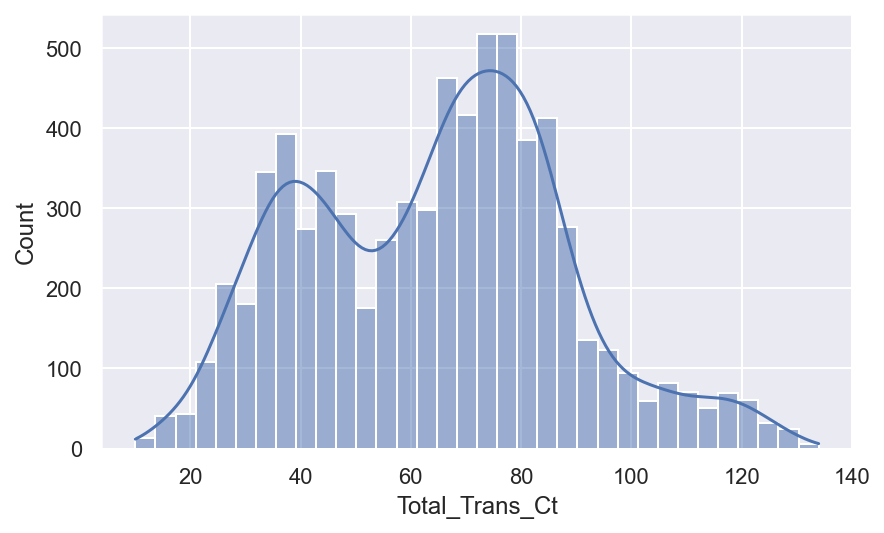

In [106]:
sns.histplot(df['Total_Trans_Ct'], kde=True)

<AxesSubplot:xlabel='Total_Trans_Ct', ylabel='Count'>

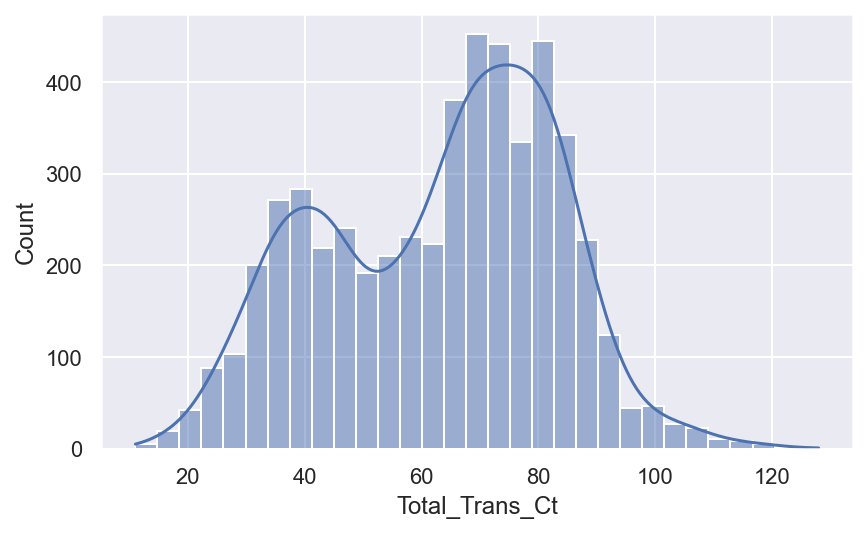

In [107]:
# only isolation
sns.histplot(removed_outlier['Total_Trans_Ct'], kde=True)

In [23]:
# Finished cleaning dataset
removed_outlier

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,M,Graduate,Married,$40K - $60K,Blue,44,2,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
1,Existing Customer,F,Graduate,Married,Less than $40K,Blue,57,2,48,5,2,2,2436.0,680,1756.0,1.190,1570,29,0.611,0.279
2,Existing Customer,F,Graduate,Single,Less than $40K,Blue,41,3,28,6,1,2,7768.0,1669,6099.0,0.797,1051,22,0.833,0.215
3,Existing Customer,F,College,Single,Less than $40K,Blue,55,1,36,4,2,1,3520.0,1914,1606.0,0.510,1407,43,0.483,0.544
4,Existing Customer,M,High School,Married,$80K - $120K,Blue,46,3,40,4,3,3,19458.0,1435,18023.0,0.787,1217,27,0.800,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,Attrited Customer,F,Uneducated,Married,$40K - $60K,Blue,49,4,36,5,2,3,4167.0,0,4167.0,0.581,7590,87,0.776,0.000
4359,Attrited Customer,M,High School,Married,$80K - $120K,Blue,51,1,36,4,3,4,22754.0,0,22754.0,0.799,8531,77,0.791,0.000
4360,Attrited Customer,M,Graduate,Divorced,$80K - $120K,Blue,47,4,39,4,3,4,17504.0,476,17028.0,0.892,10468,66,0.737,0.027
4361,Attrited Customer,F,High School,Married,Less than $40K,Blue,44,1,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000


## Feature selction

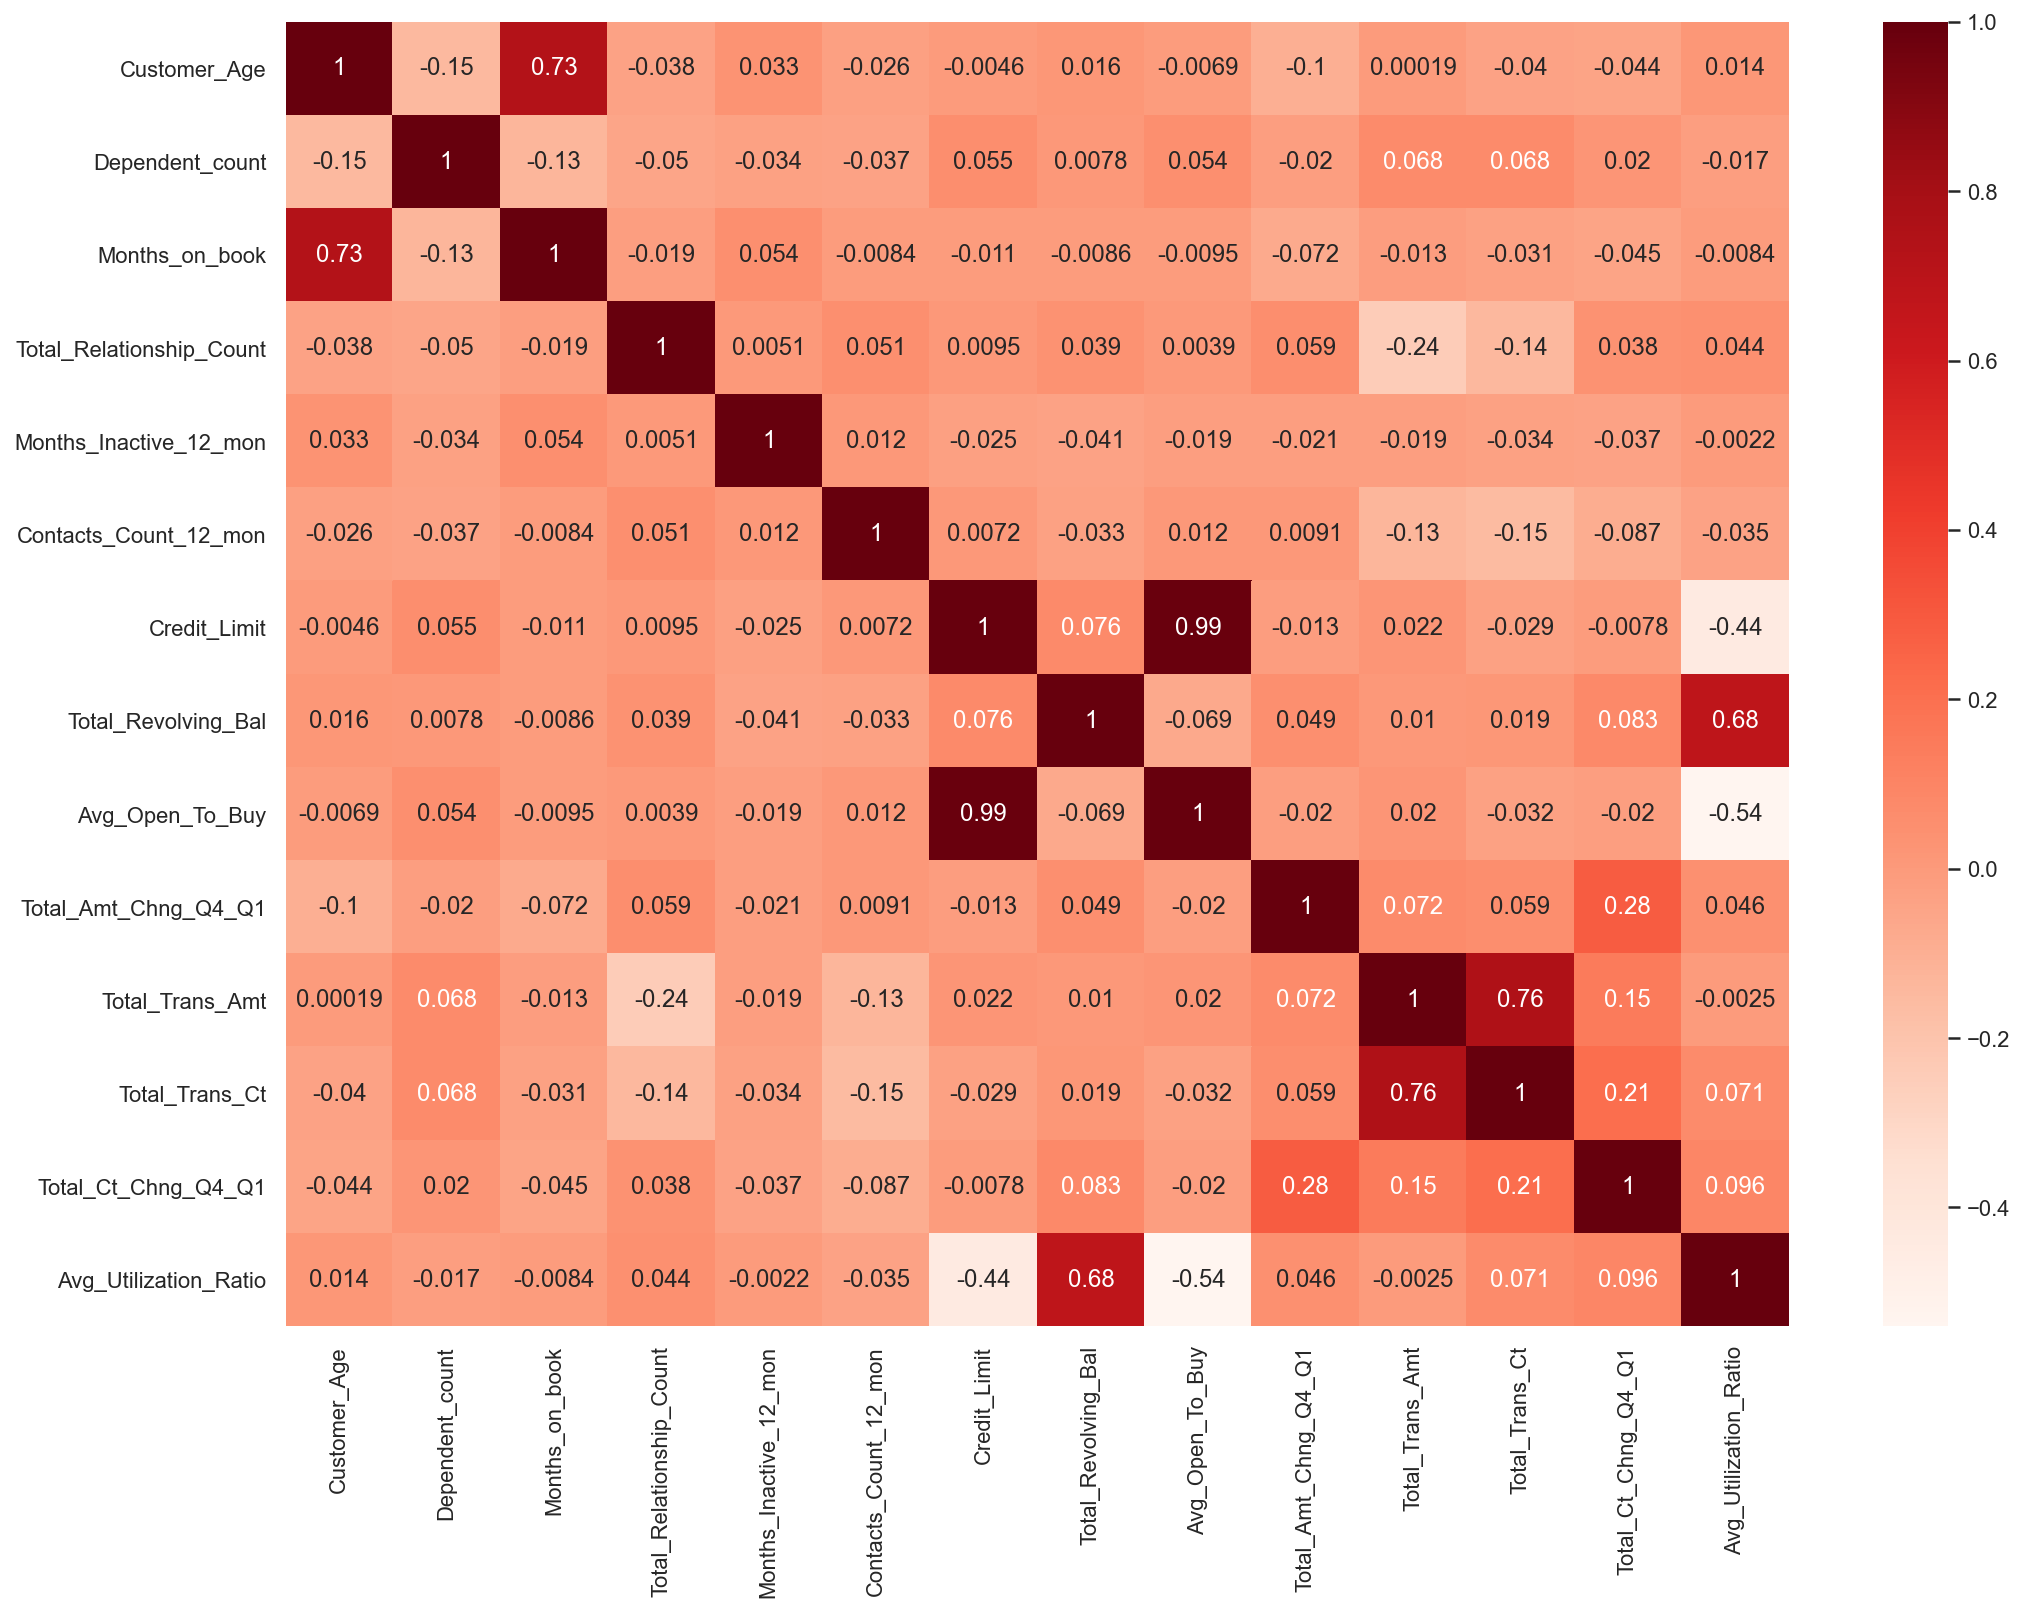

In [102]:
# Pearson correlation
plot_pearson_corrs(removed_outlier.select_dtypes(include=['number']),15,12)

### The reasons
- Total_Trans_Ct: Has a high relationship with Total_Trans_Amt
- Avg_Open_To_Buy: Has a high relationship with Credit_Limit
#### Due to high correlation, these columns can be used to represent each others.

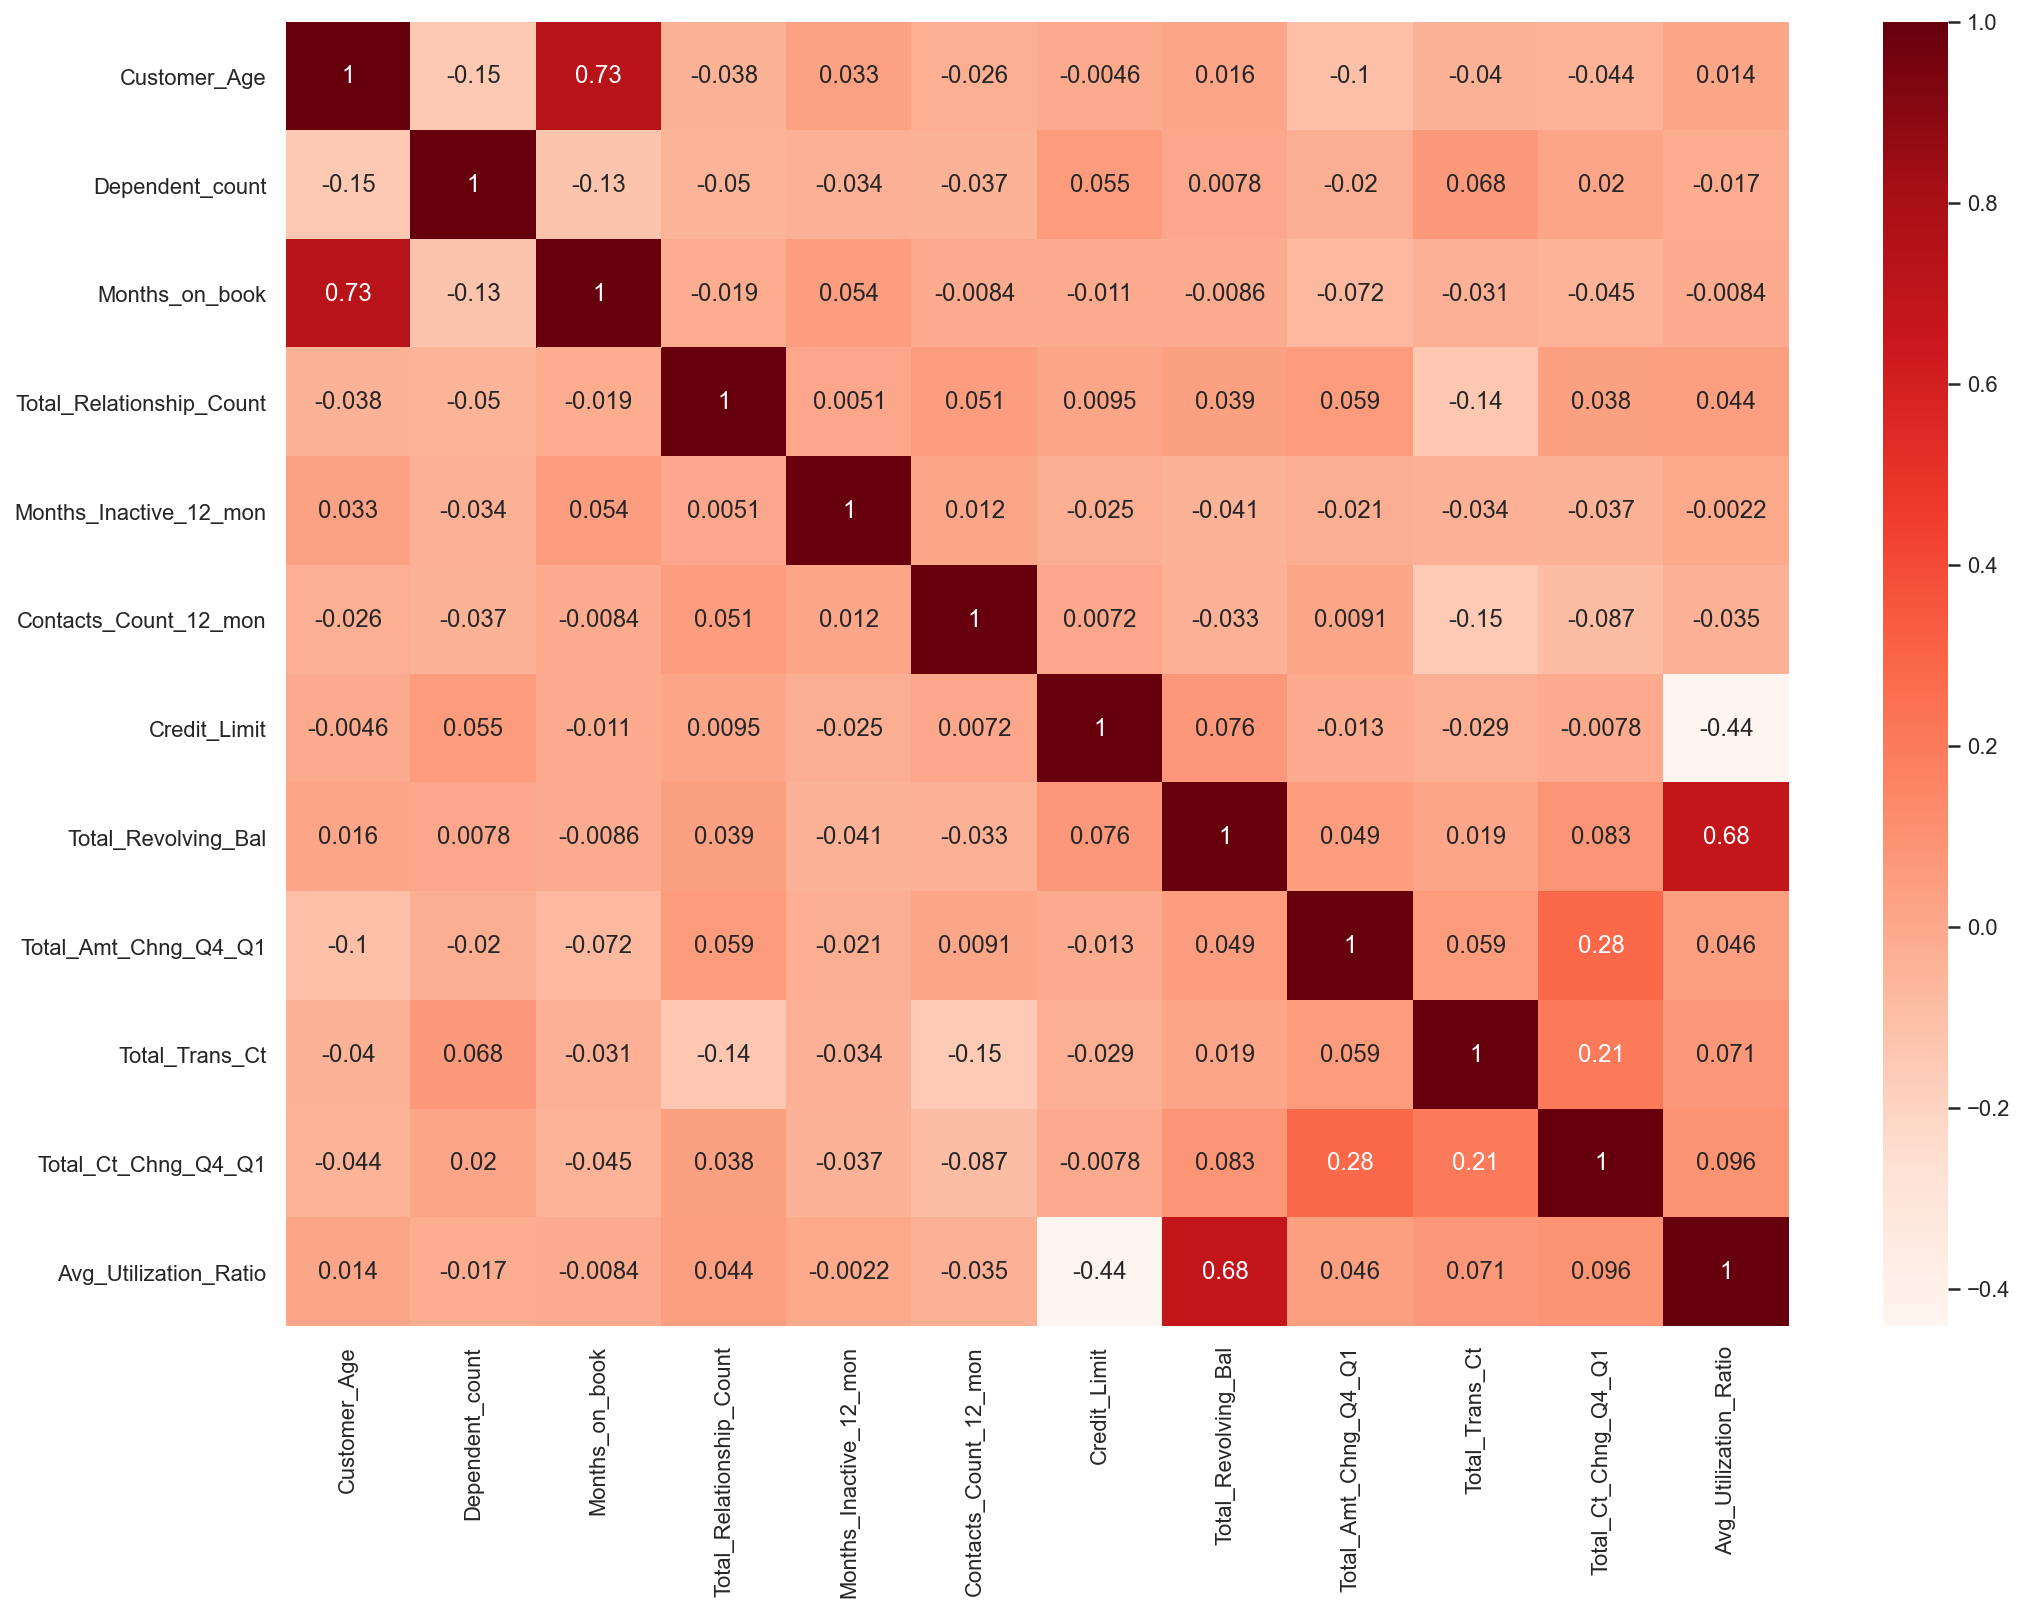

In [103]:
# Drop high correlation
plot_pearson_corrs(removed_outlier.select_dtypes(include=['number']).drop(['Total_Trans_Amt','Avg_Open_To_Buy'],axis=1),15,12)

In [109]:
# Chi-square test (alpha: 0.05)
Chi_square_test(df,'Attrition_Flag').sort_values('p-value', ascending=False)

,column name,p-value
4,Card_Category,0.759710
2,Marital_Status,0.119615
1,Education_Level,0.044879
3,Income_Category,0.015177
0,Gender,0.003255


In [120]:
# Drop the columns that don't have relationship with the target values 'Attrition_Flag' (p-value > alpha)
# - Card_Category
# - Education_Level
cleaned_data = removed_outlier.drop(['Card_Category','Education_Level'],axis=1)

In [121]:
cleaned_data

,Attrition_Flag,Gender,Marital_Status,Income_Category,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,M,Married,$40K - $60K,44,2,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
1,Existing Customer,M,Single,$80K - $120K,48,2,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144
2,Existing Customer,F,Married,Less than $40K,57,2,48,5,2,2,2436.0,680,1756.0,1.190,1570,29,0.611,0.279
3,Existing Customer,F,Single,Less than $40K,41,3,28,6,1,2,7768.0,1669,6099.0,0.797,1051,22,0.833,0.215
4,Existing Customer,F,Married,Less than $40K,53,2,38,5,2,3,2650.0,1490,1160.0,1.750,1411,28,1.000,0.562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,Attrited Customer,M,Divorced,$80K - $120K,47,4,39,4,3,4,17504.0,476,17028.0,0.892,10468,66,0.737,0.027
5238,Existing Customer,M,Single,$60K - $80K,49,1,40,6,3,3,6481.0,1569,4912.0,0.692,15937,119,0.803,0.242
5239,Existing Customer,M,Single,$40K - $60K,38,1,36,2,3,2,5639.0,1558,4081.0,0.614,16628,109,0.946,0.276
5240,Attrited Customer,F,Married,Less than $40K,44,1,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000


In [122]:
# Apply One-hot encoding on categorical columns
cleaned_df = pd.get_dummies(cleaned_data.drop('Attrition_Flag',axis=1))

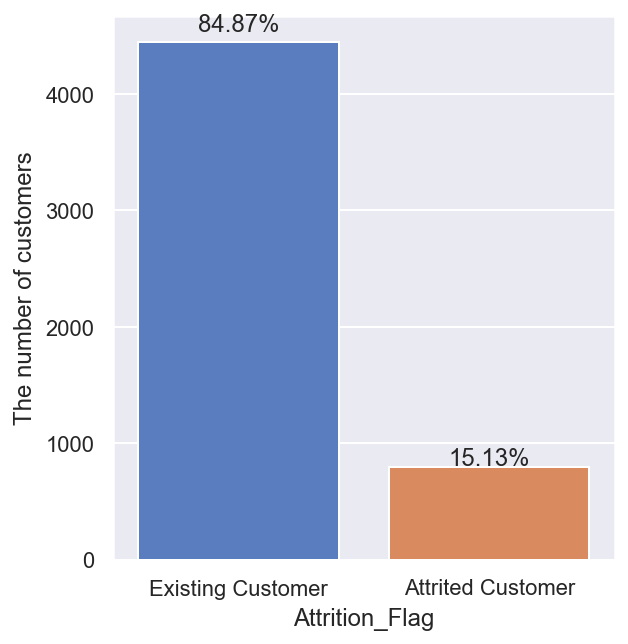

In [129]:
countplot(clean_data,'Attrition_Flag')

In [124]:
# Declare a target
y = removed_outlier['Attrition_Flag'].copy()

# Declare features
X = cleaned_df.copy()
X.head()

# Split the data to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [125]:
clf = xgb.XGBClassifier(objective='binary:logistic', seed=42, eval_metric='auc')
clf.fit(X_train,
        y_train,
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='auc',
        eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.93896
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.94859
[2]	validation_0-auc:0.95751
[3]	validation_0-auc:0.96706
[4]	validation_0-auc:0.97062
[5]	validation_0-auc:0.97328
[6]	validation_0-auc:0.97547
[7]	validation_0-auc:0.97581
[8]	validation_0-auc:0.97732
[9]	validation_0-auc:0.97920
[10]	validation_0-auc:0.97986
[11]	validation_0-auc:0.98017
[12]	validation_0-auc:0.98351
[13]	validation_0-auc:0.98427
[14]	validation_0-auc:0.98520
[15]	validation_0-auc:0.98534
[16]	validation_0-auc:0.98664
[17]	validation_0-auc:0.98668
[18]	validation_0-auc:0.98696
[19]	validation_0-auc:0.98708
[20]	validation_0-auc:0.98742
[21]	validation_0-auc:0.98712
[22]	validation_0-auc:0.98741
[23]	validation_0-auc:0.98740
[24]	validation_0-auc:0.98789
[25]	validation_0-auc:0.98816
[26]	validation_0-auc:0.98856
[27]	validation_0-auc:0.98868
[28]	validation_0-auc:0.98865
[29]	validation_0-auc:0.98864
[30]	validation_0-auc:0.98882
[31]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

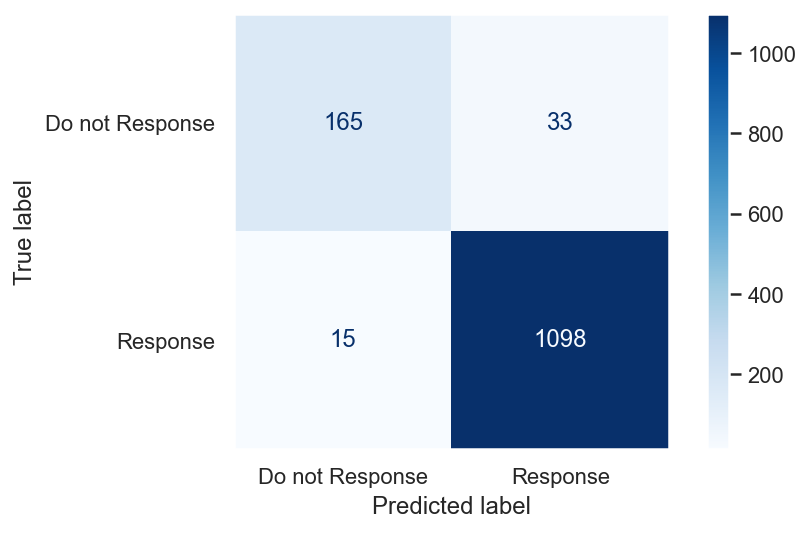

In [126]:
# Plot confusion matrix 
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      cmap = 'Blues',
                      values_format = 'd',
                      display_labels = ['Do not Response','Response'])
# Hide background grid
plt.grid(b=None)

In [128]:
clf.get_booster().get_score(importance_type="gain")

{'Total_Trans_Ct': 13.689271883656684,
 'Total_Revolving_Bal': 9.01951021679284,
 'Months_Inactive_12_mon': 3.882072773740667,
 'Total_Trans_Amt': 3.869525449856518,
 'Customer_Age': 1.720800443823333,
 'Total_Ct_Chng_Q4_Q1': 3.007172127037929,
 'Total_Amt_Chng_Q4_Q1': 2.689581215708764,
 'Total_Relationship_Count': 5.1699208455339285,
 'Dependent_count': 0.8101752282064517,
 'Avg_Open_To_Buy': 1.795209105773334,
 'Contacts_Count_12_mon': 1.5862087891454544,
 'Avg_Utilization_Ratio': 1.586525936547059,
 'Credit_Limit': 1.1682442622693172,
 'Months_on_book': 0.6760930566181821,
 'Income_Category_$80K - $120K': 0.52291919,
 'Income_Category_Less than $40K': 0.698175645,
 'Gender_F': 1.0240897138615384,
 'Income_Category_$60K - $80K': 2.0272007,
 'Marital_Status_Married': 0.8105671142500003,
 'Marital_Status_Single': 0.5690576027500001,
 'Marital_Status_Divorced': 1.18206054725,
 'Income_Category_$120K +': 0.354751348,
 'Income_Category_$40K - $60K': 0.13393691915}